In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 32.1814641953s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.63643288612s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.191356897354s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

# add a negative control
perturbations = np.union1d(perturbations, 'NegCtrl0_NegCtrl0')
single_gene_perturbations['negative'] = 'NegCtrl0_NegCtrl0'
fitnesses['NegCtrl0_NegCtrl0'] = 0.0

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Clustering

In [10]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='correlation',
                            min_cluster_size=4,
                            min_samples=1,
                            cluster_selection_method='eom',
                            alpha=1.)

data = mean_pop.where(genes='mean > 0.25',
                      normalized=True,
                      gene_names=True
                     )
data = data/data.std()

clusterer.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='correlation', min_cluster_size=4, min_samples=1, p=None,
    prediction_data=False)

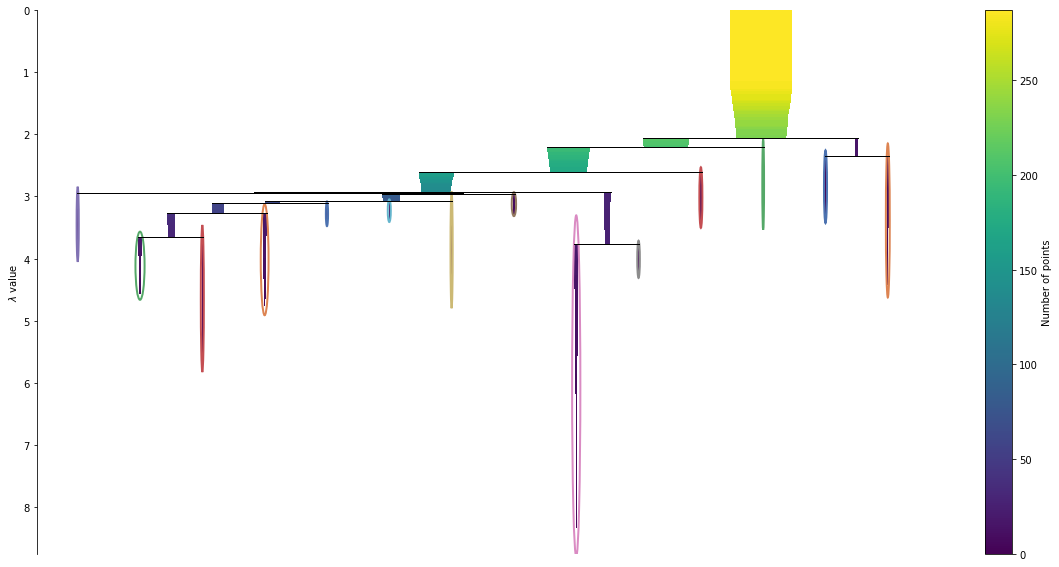

In [11]:
plt.figure(figsize=[20,10])
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 40))

In [12]:
from scipy.cluster.hierarchy import leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import shuffle
from matplotlib.colors import to_hex

In [13]:
D_corr = pdist(data, 'correlation')
Z_corr = clusterer.single_linkage_tree_.to_numpy()
Z_corr = optimal_leaf_ordering(Z_corr, D_corr)
labels = pd.Series(clusterer.labels_, index=data.index).sort_values()
clusters_in_order = labels.loc[data.index.values[leaves_list(Z_corr)]]

cluster_colors = map(to_hex, sns.color_palette('hls', labels.max()+2))
cluster_colors = shuffle(cluster_colors)
cluster_color_mapper = dict(zip(sorted(labels.unique()), cluster_colors))
cluster_color_mapper[-1] = '#cccccc'
cluster_colors = clusters_in_order.map(lambda x: cluster_color_mapper[x])

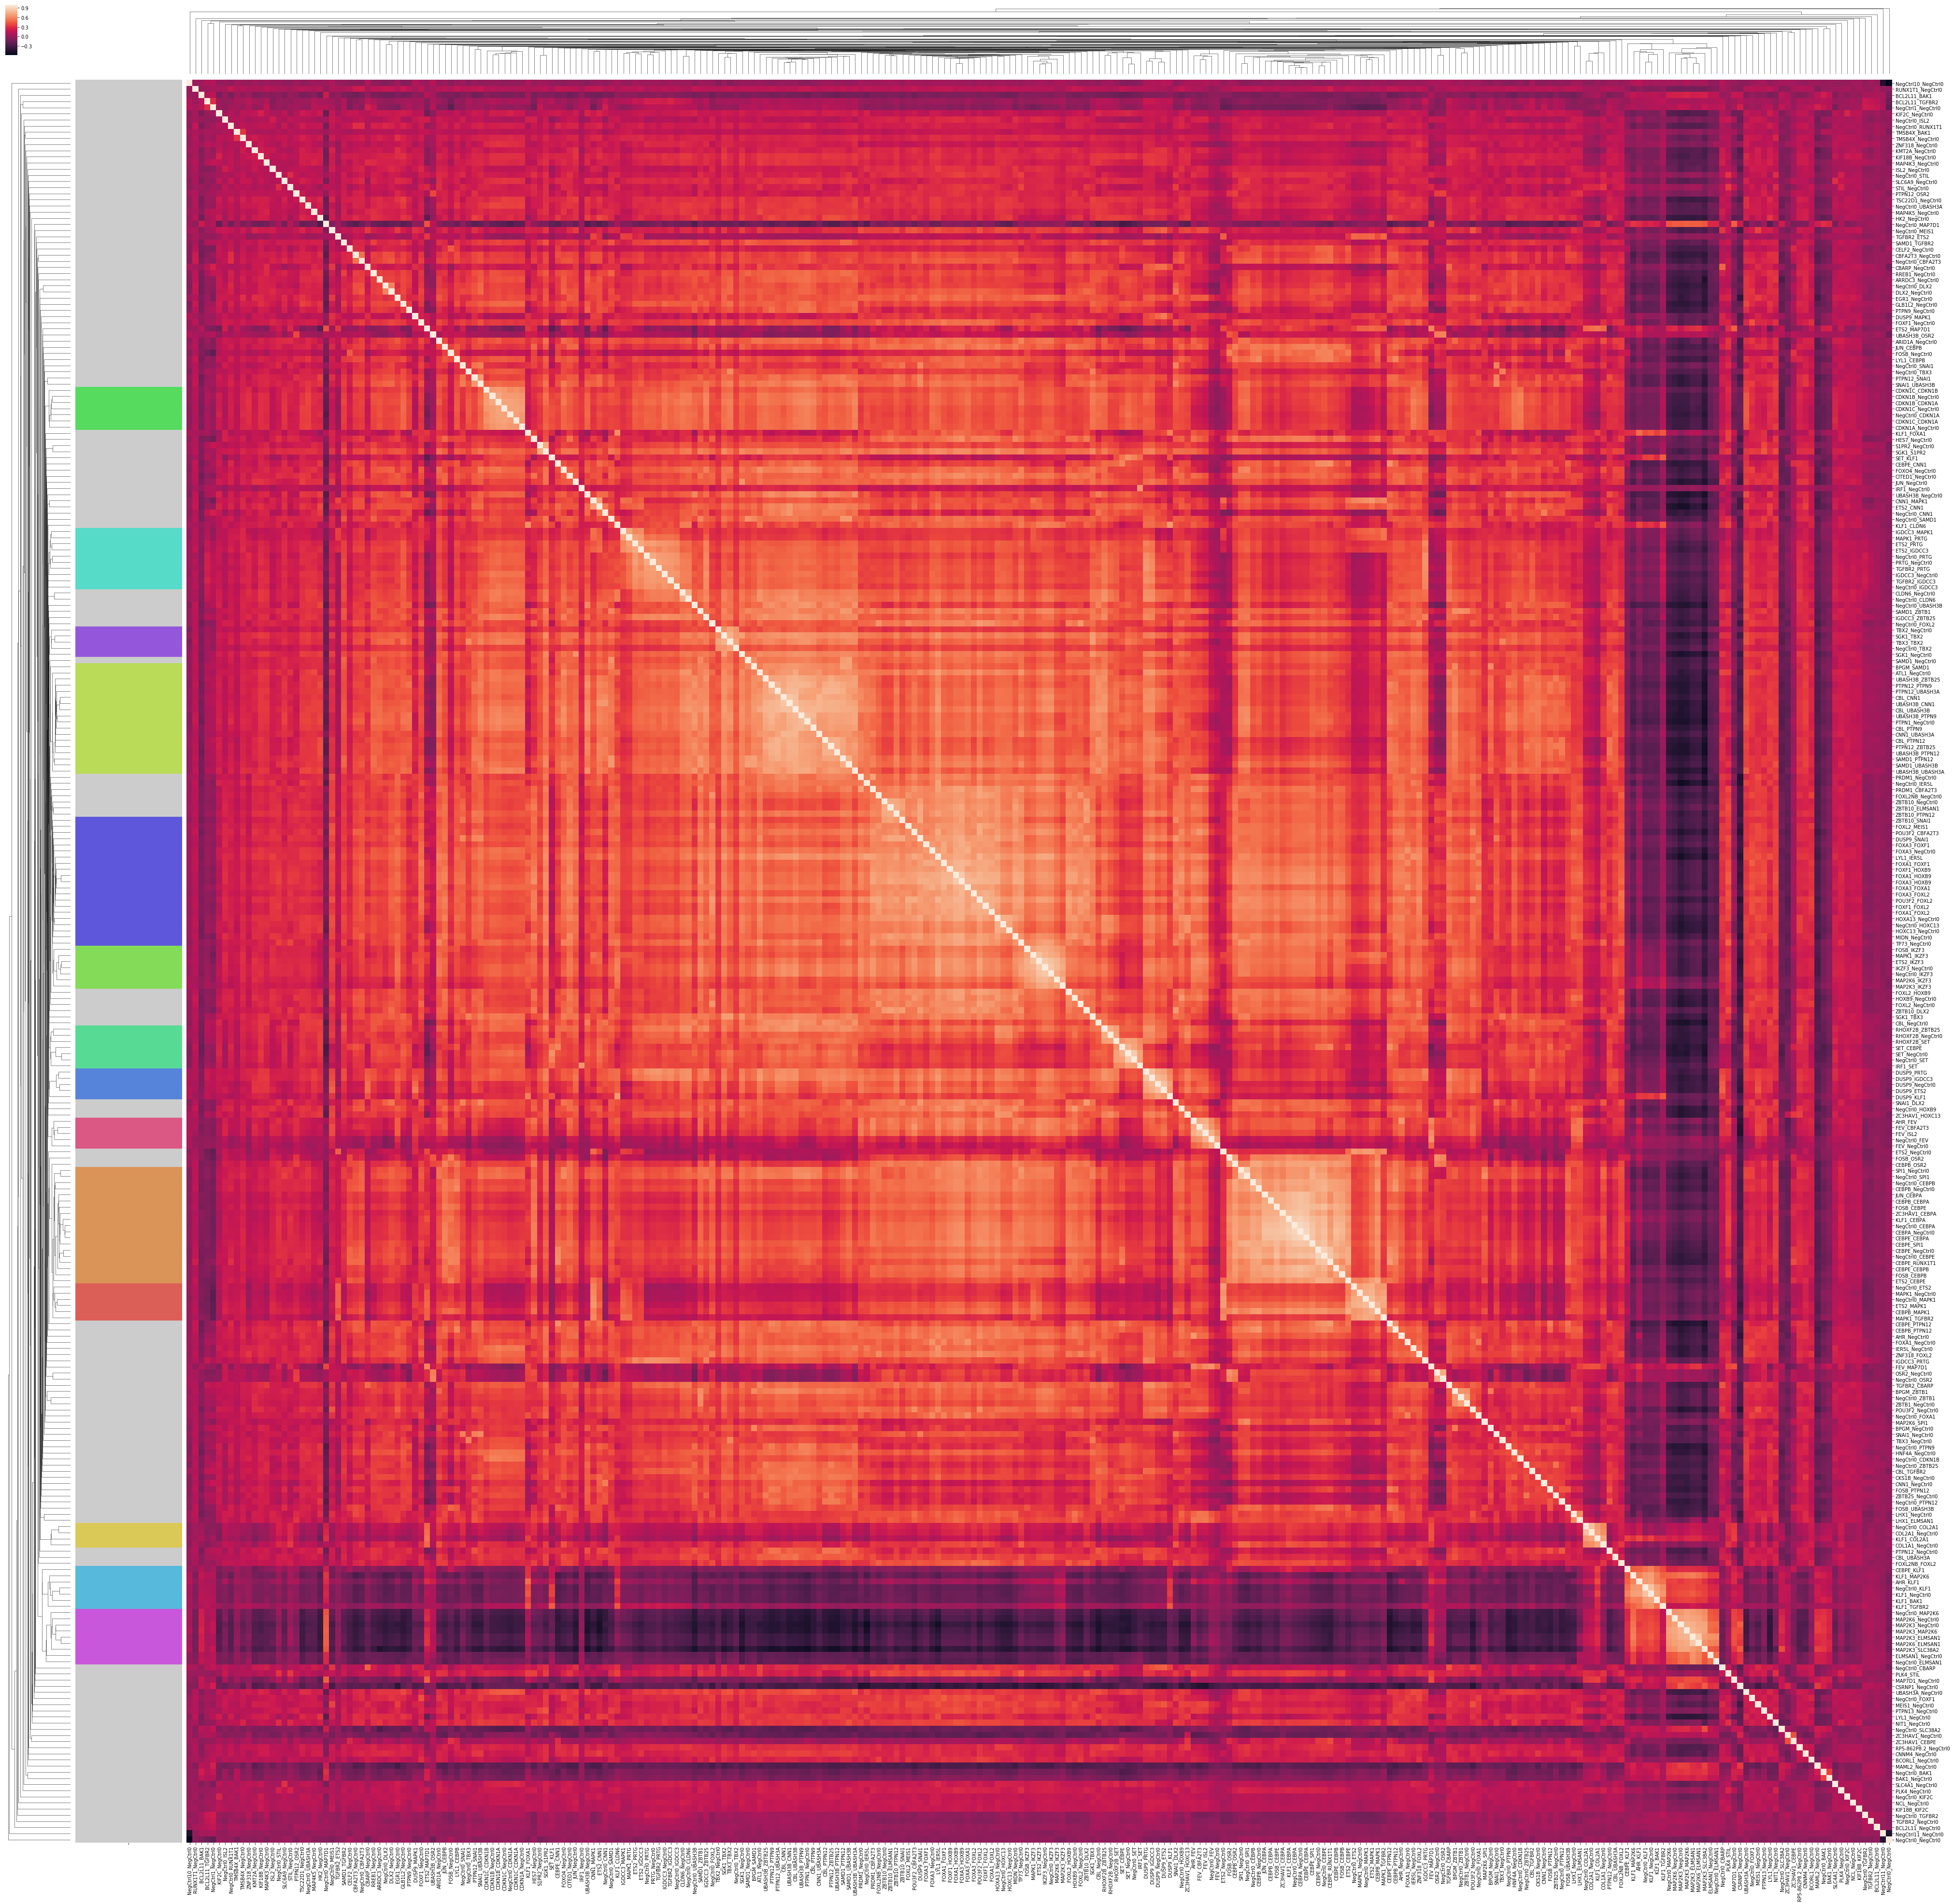

In [14]:
sns.clustermap(data.T.corr(), 
               row_linkage=Z_corr, col_linkage=Z_corr,
               robust=False, figsize=[70,70], row_colors=cluster_colors)

# Optimal UMAP

In [15]:
from umap import UMAP

The particular random_state used for the embedding was originally chosen by running 10,000 iterations and picking the result with the highest distance correlation with the original expression data. The embedding is relatively insensitive to this choice but it makes it somewhat less ad hoc.

In [16]:
# from onesense import optimal_umap

# x, random_state, random_scores = optimal_umap(data,
#                                               10000,
#                                               n_jobs=1,
#                                               metric='correlation',
#                                               n_neighbors=10,
#                                               min_dist=1,
#                                               spread=2)

Embed mean expression profiles using UMAP

In [17]:
transformer = UMAP(metric='correlation',
                   n_neighbors=10,
                   min_dist=1,
                   spread=2,
                   random_state=45305)

coords = pd.DataFrame(transformer.fit_transform(data),
                      index=data.index,
                      columns=['x', 'y'])
coords['color'] = cluster_colors
coords['cluster'] = clusters_in_order
coords.to_csv('./data_sharing/optimal_umap_layout.csv')

(85, 125)

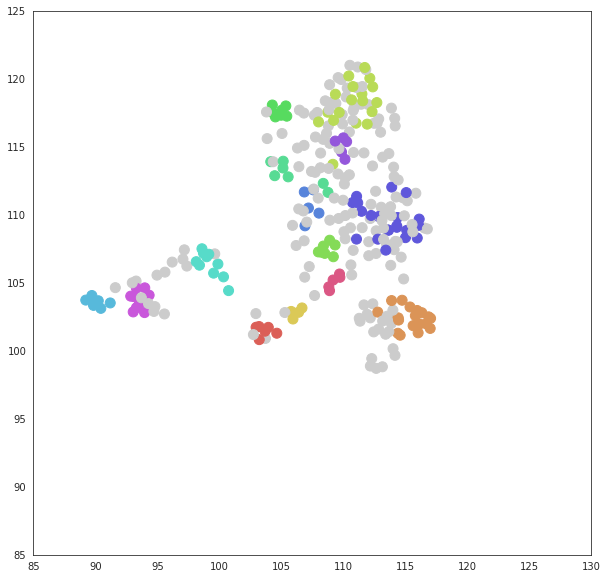

In [18]:
sns.set_style('white')
plt.figure(figsize=[10,10])
plt.scatter(coords['x'], coords['y'], c=coords['color'], s=100)
plt.xlim(85, 130)
plt.ylim(85, 125)

This makes the large version with labels. It takes quite a while to execute because of the optimization of label placement.

In [19]:
# coords.index = coords.index.str.replace('NegCtrl0', 'ctrl').str.replace('NegCtrl', 'ctrl').str.replace('_', ' / ')

# from adjustText import adjust_text

# plt.figure(figsize=[24,24])
# plt.scatter(coords['x'], coords['y'], c=coords['color'], s=100)
# texts = list()
# small_texts = list()
# for name, row in coords.iterrows():
#     if row['color'] != '#cccccc':
#         texts.append(plt.text(row['x'], row['y'], name, fontsize=10))
#     else:
#         small_texts.append(plt.text(row['x'], row['y'], name, fontsize=8, color='gray'))
# plt.xlim(83, 125)
# plt.ylim(95, 125)
# plt.axis('off');
# adjust_text(texts, lim=1000)
# adjust_text(small_texts, lim=1000)
# plt.savefig('./figures/optimal_UMAP.pdf')

# Single-cell UMAP

In [20]:
single_cell_data = pop.where(genes=data.columns,
                      normalized=True,
                      gene_names=True
                     )
data = data/data.std()

We use UMAP's ability to embed new data to place single cells within the mean UMAP projection. 

In [21]:
single_cell_coords = pd.DataFrame(transformer.transform(single_cell_data),
                      index=single_cell_data.index,
                      columns=['x', 'y'])

This matches the colors in the original main text figure

In [22]:
main_fig_color_mapper   = {0: '#DB904E',
                           1: '#DC574E',
                           2: '#C757A1',
                           3: '#7F5AA5',
                           4: '#67C18A',
                           5: '#4DB9DD',
                           6: '#DAEDC7',
                           7: '#64C6BB',
                           8: '#B6D54E',
                           9: '#557CBE',
                           10: '#6BBF56',
                           11: '#D94E81',
                           12: '#575BA8',
                           13: '#D8C64B',
                           -1: '#D1D2D4',
                           }

In [23]:
single_cell_coords['color'] = pop.cells['guide_target'].map(lambda x: main_fig_color_mapper[clusters_in_order[x]])

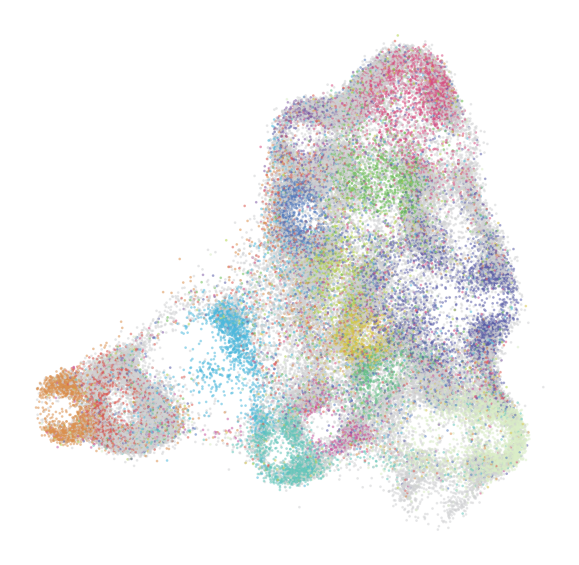

In [24]:
sns.set_style('white')
plt.figure(figsize=[10,10])
fig = plt.scatter(single_cell_coords['x'], single_cell_coords['y'], c=single_cell_coords['color'], s=3, alpha=0.4)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.box(False)
plt.savefig('./figures/single_cell_umap.png', dpi=300)

# Cell cycle

In [25]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage

In [26]:
cell_cycle_order = {'M': '0_M', 'M-G1': '1_M-G1', 'G1-S': '2_G1-S', 'S': '3_S', 'G2-M': '4_G2-M'}
pop.cells['ordered_cell_cycle_phase'] = pop.cells['cell_cycle_phase'].map(cell_cycle_order)

cell_cycle_data = pop.cells.groupby(['guide_target', 'ordered_cell_cycle_phase']).count()[['single_cell']].groupby(level=[0]).transform(lambda x: x/x.sum()).reset_index()
cell_cycle_table = cell_cycle_data.pivot(index='guide_target', columns='ordered_cell_cycle_phase').fillna(0)

Z_cell_cycle = linkage(cell_cycle_table, method='average', metric='correlation', optimal_ordering=True)

normalized_cell_cycle_table = cell_cycle_table.sub(cell_cycle_table.loc['NegCtrl0_NegCtrl0']).div(cell_cycle_table.loc['NegCtrl0_NegCtrl0'])

Look for deviations in the occupancy of different cell cycle stages relative to control cells

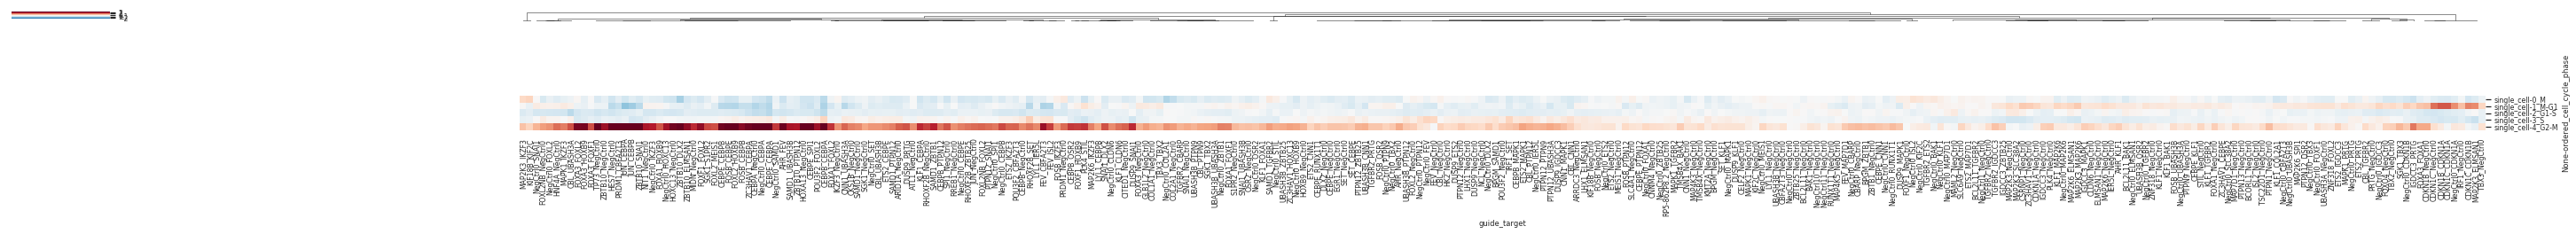

In [27]:
sns.set(font_scale=0.7)
sns.clustermap(normalized_cell_cycle_table.T,
               square=True,
               row_cluster=False,
               col_linkage=Z_cell_cycle,
               vmin=-2.5, vmax=2.5,
               cmap='RdBu_r',
               figsize=[50, 4])

Summarize these differences by the correlation between the distribution of occupancies in control cells and that in each perturbed subpopulation

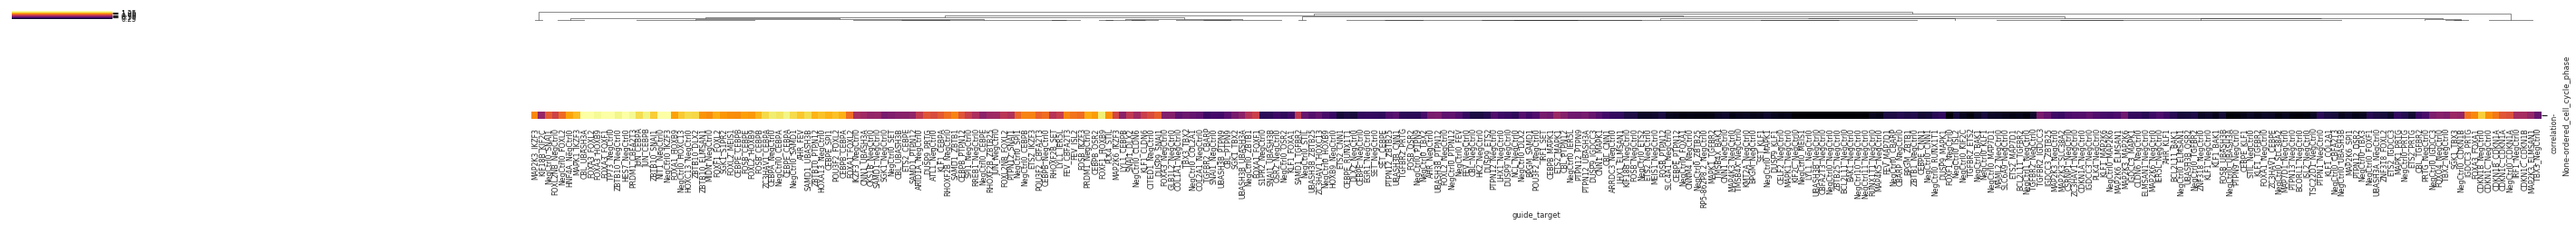

In [28]:
cc_correlations = cell_cycle_table.apply(lambda x: 1 - x.corr(cell_cycle_table.loc['NegCtrl0_NegCtrl0']), axis=1)
cell_cycle_table['correlation'] = cc_correlations


sns.set(font_scale=0.7)
sns.clustermap(cell_cycle_table[['correlation']].T,
               square=True,
               row_cluster=False,
               col_linkage=Z_cell_cycle,
               figsize=[50, 4],
               robust=True,
              cmap=plt.cm.get_cmap('inferno'))

In [29]:
cell_cycle_table.to_csv('./data_sharing/mean_pop_cell_cycle.csv')

# Data mapped onto embedding

In [30]:
def figure_styles():

    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')

figure_styles()

## Cell cycle

In [31]:
normalized_cell_cycle_table = cell_cycle_table.sub(cell_cycle_table.loc['NegCtrl0_NegCtrl0']).div(cell_cycle_table.loc['NegCtrl0_NegCtrl0'])

In [32]:
ordered_cell_cycle_perturbations = ['NegCtrl0_CDKN1A', 'NegCtrl0_CDKN1B', 'CDKN1C_NegCtrl0', 'CDKN1C_CDKN1A', 'CDKN1C_CDKN1B',
                                   'PLK4_NegCtrl0', 'NegCtrl0_STIL', 'PLK4_STIL', 'CKS1B_NegCtrl0',
                                   'KIF18B_NegCtrl0', 'NegCtrl0_KIF2C', 'KIF18B_KIF2C']

In [33]:
cc_table = normalized_cell_cycle_table.loc[ordered_cell_cycle_perturbations, 'single_cell']
cc_table.index = cc_table.index.map(lambda x: x.replace('_', ' / ').replace('NegCtrl0', 'ctrl'))

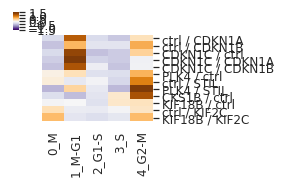

In [34]:
cg = sns.clustermap(cc_table,
               col_cluster=False, row_cluster=False,
               vmin=-1.5, vmax=1.5,
               cmap=plt.cm.get_cmap('PuOr_r'),
               figsize=[2.5,2], yticklabels=True)
ax = cg.ax_heatmap
ax.set_xlabel('')
ax.set_ylabel('')
cg.savefig('./figures/umap_cell_cycle_table.pdf', bbox_inches='tight')

In [35]:
coords['cell_cycle_correlation'] = cell_cycle_table['correlation']

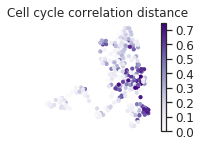

In [36]:
sns.set_style('white')
plt.figure(figsize=[2.5,2])
plt.scatter(coords['x'],
            coords['y'],
            c=coords['cell_cycle_correlation']/2,
            cmap=plt.cm.get_cmap('Purples'),
            s=10, vmin=0, vmax=.75)
plt.colorbar()
plt.axis('off');
plt.title('Cell cycle correlation distance');
plt.savefig('./figures/umap_cell_cycle_correlation.pdf', bbox_inches='tight')

## Fitness

In [37]:
coords['fitness'] = mean_pop.cells['fitness']

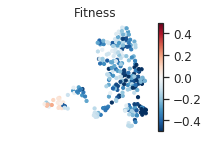

In [38]:
sns.set_style('white')
plt.figure(figsize=[2.5,2])
plt.scatter(coords['x'],
            coords['y'],
            c=coords['fitness'],
            cmap=plt.cm.get_cmap('RdBu_r'),
            s=10, vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.axis('off');
plt.title('Fitness');
plt.savefig('./figures/umap_fitness.pdf', bbox_inches='tight')

## Fitness GI map scores

In [39]:
emap_scores = dict()
for pair in mean_pop.cells.index:
    if 'NegCtrl' not in pair:
        first, second = pair.split('_')
        emap_scores[pair] = emap.loc[first, second]
emap_scores = pd.Series(emap_scores)
coords['emap'] = emap_scores
coords['emap'].fillna(0, inplace=True)

In [40]:
interacting = coords['emap'].abs() > 1
noninteracting = ~interacting

In [41]:
#### colormap
#'#20B6E2' -> '#F4EA18'
# 32,182,226 -> 244,234,24
# .125, .713, .886 -> .957, .918, .094
cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad((.9, .9, .9, 1.0))
plt.register_cmap(cmap=blue_yellow)

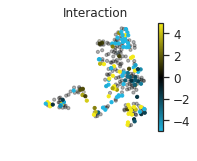

In [42]:
sns.set_style('white')
plt.figure(figsize=[2.5,2])

plt.scatter(coords.loc[noninteracting, 'x'],
            coords.loc[noninteracting, 'y'],
            c=coords.loc[noninteracting, 'emap'],
            cmap=plt.cm.get_cmap('BlueYellow'),
            s=10, alpha=0.3, vmin=-5, vmax=5)


plt.scatter(coords.loc[interacting, 'x'],
            coords.loc[interacting, 'y'],
            c=coords.loc[interacting, 'emap'],
            cmap=plt.cm.get_cmap('BlueYellow'),
            s=10, vmin=-5, vmax=5)
plt.colorbar()

plt.axis('off');
plt.title('Interaction');
plt.savefig('./figures/umap_emap.pdf', bbox_inches='tight')

## Developmental markers

In [43]:
import matplotlib

In [44]:
def normalize_data(data, cmap, vmin, vmax, clip_min=None):
    cm = plt.cm.get_cmap(cmap)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    c = pd.DataFrame(np.asarray([cm(norm(x)) for x in data]),
                    index=coords.index,
                    columns=['r', 'g', 'b', 'a'])
    c['a'] = pd.Series([x for x in data], index=data.index)
    c['a'] = ((c['a'] - c['a'].quantile(0.2))/c['a'].quantile(0.8)).clip(lower=0, upper=1)
    if clip_min is not None:
        clip_ind = data[data < clip_min].index
        c.loc[clip_ind, 'a'] = 0.
    return c

In [45]:
ery_markers = ['HBG1', 'HGB2', 'HBZ', 'HGA1', 'HBA2', 'GYPA', 'ERMAP']
coords['ery_score'] = mean_pop.where(genes=ery_markers, normalized=True).mean(axis=1)

gran_markers = ['ITGAM', 'CSF3R', 'LST1', 'CD33']
coords['gran_score'] = mean_pop.where(genes=gran_markers, normalized=True).mean(axis=1)

coords['CD41'] = mean_pop.normalized_matrix[pop.gene_ids('ITGA2B')]

In [46]:
c1 = normalize_data(coords['ery_score'], 'Oranges', 1, 5, clip_min=1)
c2 = normalize_data(coords['gran_score'], 'Purples', 1, 10, clip_min=1)
c3 = normalize_data(coords['CD41'], 'Greens', 0, 1, clip_min=0.5)

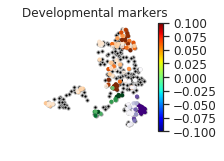

In [47]:
sns.set_style('white')
m = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.jet)
m.set_array(coords['fitness'])

plt.figure(figsize=[2.5,2])

plt.scatter(coords['x'],
            coords['y'],
            facecolors='black',
            edgecolors='darkgray',
            s=10)

plt.scatter(coords['x'],
            coords['y'],
            c=c1.values,
            s=10,)

plt.scatter(coords['x'],
            coords['y'],
            c=c2.values,
            s=10)

plt.scatter(coords['x'],
            coords['y'],
            c=c3.values,
            s=10)
plt.colorbar(m)


plt.axis('off');
plt.title('Developmental markers');
plt.savefig('./figures/umap_developmental.pdf', bbox_inches='tight')

# Cluster analysis

In [48]:
clusters = clusters_in_order[clusters_in_order != -1]

In [49]:
expr = mean_pop.where(cells=clusters.index,
                      genes='mean > 0.1 and gene_name not in @single_genes',
                      normalized=True,
                      gene_names=True,
                      dropna=True,
                     single_genes=single_genes)

In [51]:
cluster_names = {1: 'pro-growth', 2: 'col2a1', 3: 'cell_cycle', 4: 'fev', 5: 'prtg',
         6: 'gran', 7: 'mapk1', 8: 'dusp9', 9: 'set', 10: 'tbx', 11: 'ery', 12: 'pioneer', 13: 'ikzf3'}

expr['cluster'] = clusters.values
expr['cluster'] = expr['cluster'].map(lambda x: cluster_names[x] if x != 0 else 'unclustered')
cluster_expr = expr.groupby('cluster').mean()

In [52]:
for gene in cluster_expr.T.query('gran > 1').sort_values('gran', ascending=False).index:
    print gene

CLC
LST1
CSF3R
TYROBP
CFD
PNRC1
MS4A3
CORO1A
MYO1F
ARHGDIB
AIF1
LMO4
GLRX
GSN
MSRB1
ALAS1
COTL1
METTL9
SAT1
PLD3
BTG1
TNFAIP8
LYZ
VIM
RP6-159A1.4
TRPM4
CYBA
RP11-301G19.1
VAMP8
SELPLG
HVCN1
S100A11
LPCAT2
PGD
SERPINB1
PRKCB
ARPC5
HEPH
YPEL3
PYCARD
ARPC1B
BRI3
FAM101B
ACTB
CREG1
CD37
MARCH2
SH3BGRL3
CD52
ACSM3
DBI
ARHGEF6
GPR85
ORAI3
IRF2BP2
LAPTM5
TKT
RCSD1
COMMD6
LGALS1
OAZ1
APOBR
MSN
LIMD2
TPT1
CCPG1
ITM2B
TXNIP
FTL
PFDN5
NCKAP1L
COLGALT2
DSCR8
ATP6V0E1
ZFP36L2
SLC44A1
TRIM38
FCER1G
IFITM2
MALAT1
USP20
PLAUR
HSD17B4
GPSM3
MYH9
FCGRT
SKAP2
GMFG
TNNT1
FNDC3B
CD63
LRMP
PLP2
KIAA1551
SH3BGRL
ROGDI
RUNX1
CNN2
LCP1
HLA-C
NINJ1
HOTAIRM1
AAK1
TPM4
TLE4
PPP1R18
B2M
RP11-620J15.3
TMEM154
CLU
HLA-E
ARL11
MARCKSL1
TMSB10
ACAA1
TPP1
P4HB
NCOA4
WSB1
DUSP22
GNAI2
ARPC2
ANKRD28
N4BP2L2
SMIM14
PXK
UGP2
CD53
RNF130
EFHD2
SNX3
ICAM4
LACTB
TAPBP
C10orf11
LAMTOR1
PTK2B
TUBA1A
MBOAT7
CNTRL
DNAJC4
RHOG
HSD17B11
AIM1
RP11-467L13.7
HYAL3
IL10RB
OS9
ZEB2
RNASET2
AP1S2
ID1
STK4
PNISR
MILR1
SCPEP1
WIPI1
PSMB9
F

Submit above genelist to Enrichr...

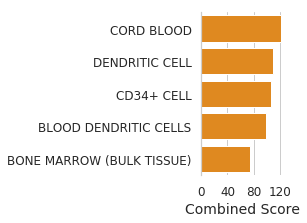

In [53]:
df = pd.read_csv('./data_sharing/myeloid_ARCHS4_Tissues_table.txt', header=[0], sep='\t')

figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="darkorange")
plt.xticks([0, 40, 80, 120])
sns.despine(right=True, bottom=True)
plt.ylabel('')
plt.savefig('./figures/erythroid_and_myeloid_myeloid_ARCH.pdf', bbox_inches='tight')

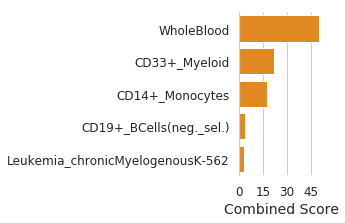

In [54]:
df = pd.read_csv('./data_sharing/myeloid_Human_Gene_Atlas_table.txt', header=[0], sep='\t')

figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="darkorange")
plt.xticks([0, 15, 30, 45])
sns.despine(right=True, bottom=True)
plt.ylabel('')
plt.savefig('./figures/erythroid_and_myeloid_myeloid_HGA.pdf', bbox_inches='tight')

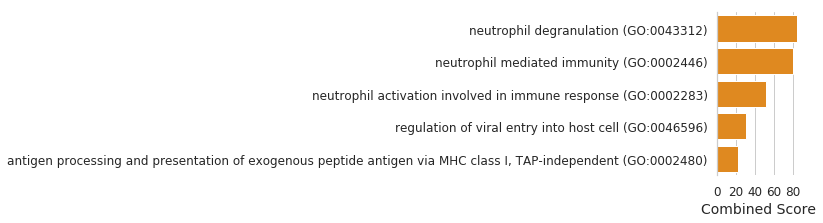

In [55]:
df = pd.read_csv('./data_sharing/myeloid_GO_Biological_Process_2018_table.txt', header=[0], sep='\t')

figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="darkorange")
plt.xticks([0, 20, 40, 60, 80])
sns.despine(right=True, bottom=True)
plt.ylabel('')
plt.savefig('./figures/erythroid_and_myeloid_myeloid_GO.pdf', bbox_inches='tight')

In [56]:
for gene in cluster_expr.T.query('ery > 1').sort_values('ery', ascending=False).index:
    print gene

HBZ
ALAS2
SLC25A37
HBA1
HBA2
HBG2
HBE1
HBG1
BLVRB
GYPB
APOE
COL18A1
APOC1
CHI3L2
LBH
SMIM1
CRYM
GYPA
MYL4
EEF1A1
REEP6
NEAT1
HEMGN
ANXA2R


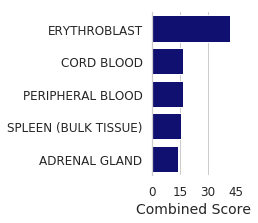

In [57]:
df = pd.read_csv('./data_sharing/erythroid_ARCHS4_Tissues_table.txt', header=[0], sep='\t')

figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="navy")
plt.xticks([0, 15, 30, 45,])
sns.despine(right=True, bottom=True)
plt.ylabel('')
plt.savefig('./figures/erythroid_and_myeloid_erythroid_ARCH.pdf', bbox_inches='tight')

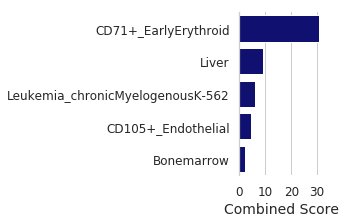

In [58]:
df = pd.read_csv('./data_sharing/erythroid_Human_Gene_Atlas_table.txt', header=[0], sep='\t')

figure_styles()
sns.set_style('whitegrid')
plt.figure(figsize=[1.5, 3])
sns.barplot(x="Combined Score", y="Term", data=df.head(5), color="navy")
plt.xticks([0, 10, 20, 30,])
sns.despine(right=True, bottom=True)
plt.ylabel('')
plt.savefig('./figures/erythroid_and_myeloid_erythroid_HGA.pdf', bbox_inches='tight')

In [59]:
probe_genes = ['CSF3R', 'ITGAL', 'CD4', 'ITGAX', 'CD55', 'CD24', 'CD33', 'ANPEP', 'GYPA', 'TFRC', 'ITGAM', 'FCGR1A', 'FCGR1B', 'IL3RA', 'PTPRC', 'HBG1', 'HBG2', 'HBA1', 'HBA2', 'HBZ', 'LST1', 'KLF1']
probe_ids = [pop.gene_ids([gene]) for gene in probe_genes] 
probe_cd_names = ['CSF3R', 'CD11a', 'CD4', 'CD11c', 'CD55', 'CD24', 'CD33', 'CD13', 'CD235a', 'CD71', 'CD11b', 'CD64a', 'CD64b', 'CD123', 'CD45', 'Hemoglobin', 'Hemoglobin', 'Hemoglobin', 'Hemoglobin', 'Hemoglobin', 'LST1', 'KLF1']
probe_full_names = {probe_genes[i]: probe_genes[i] + ' ({0})'.format(name) for i, name in enumerate(probe_cd_names)}

probe_types = ['myeloid', 'myeloid', 'myeloid', 'myeloid', 'myeloid', 'myeloid', 'myeloid', 'myeloid', 'erythroid', 'stem', 'myeloid', 'myeloid', 'myeloid', 'stem', 'stem', 'erythroid', 'erythroid', 'erythroid', 'erythroid', 'erythroid', 'myeloid', 'erythroid']

In [60]:
ery_gran_perts = expr[(expr['cluster'] == 'gran') | (expr['cluster'] == 'ery')].index
ery_gran_perts = expr[(expr['cluster'] == 'gran') | (expr['cluster'] == 'ery') | (expr['cluster'] == 'mapk1')].index

In [61]:
control_targets = ['NegCtrl0_NegCtrl0', 'NegCtrl11_NegCtrl0', 'NegCtrl10_NegCtrl0', 'NegCtrl1_NegCtrl0']

In [62]:
table = mean_pop.where(cells=ery_gran_perts,
              genes=probe_genes,
              normalized=False)
table = table.mul(mean_pop.cells.loc[control_targets, 'UMI_count'].mean()/mean_pop.cells.loc[table.index, 'UMI_count'], axis=0)

In [63]:
unpert_expr = mean_pop.where(cells=control_targets,
              genes=probe_genes,
              normalized=False)
unpert_expr = unpert_expr.mul(mean_pop.cells.loc[control_targets, 'UMI_count'].mean()/mean_pop.cells.loc[control_targets, 'UMI_count'], axis=0)
unpert_expr = unpert_expr.mean()

In [64]:
fold_table = np.log2(table/unpert_expr)
fold_table.columns = fold_table.columns.map(lambda x: probe_full_names[x])
fold_table.index = fold_table.index.str.replace('_', ' / ').str.replace('NegCtrl0', 'ctrl')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


In [65]:
fold_table = fold_table.replace({-np.inf: 0})

In [66]:
c_linkage = linkage(fold_table.T, metric='correlation', optimal_ordering=True)
r_linkage = linkage(fold_table, metric='correlation', optimal_ordering=True)

In [67]:
mapper = {'stem': 'lightslategray',
         'myeloid': 'darkorange',
         'erythroid': 'navy',}

probe_colors = pd.Series(probe_types, index=pd.Series(probe_full_names).loc[probe_genes].values).map(lambda x: mapper[x])
pert_colors = expr.loc[ery_gran_perts, 'cluster'].map(lambda x: 'cornflowerblue' if x == 'gran' else 'crimson')
pert_colors.index = pert_colors.index.str.replace('_', ' / ').str.replace('NegCtrl0', 'ctrl')

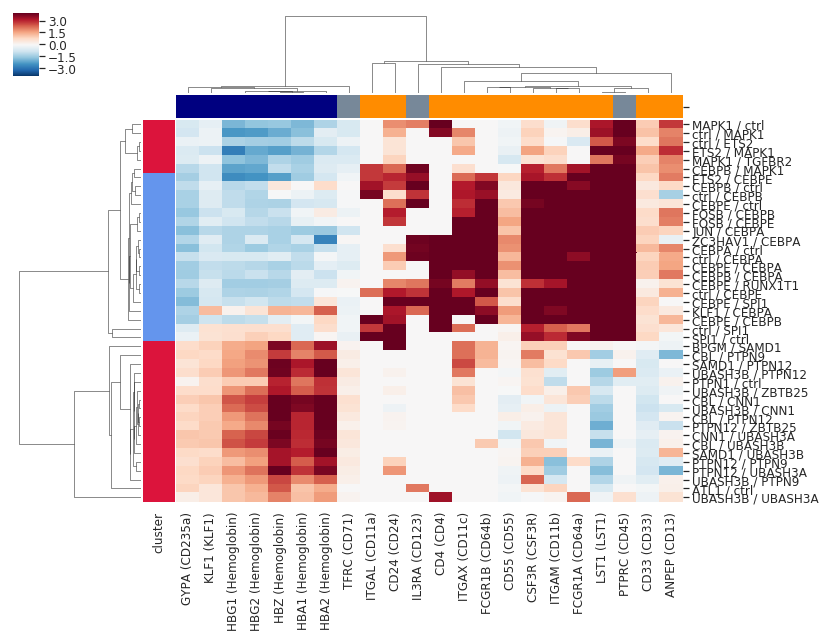

In [68]:
cg = sns.clustermap(fold_table,
               vmin=-4, vmax=4,
               xticklabels=True, yticklabels=True,
               col_linkage=c_linkage, row_linkage=r_linkage,
               col_colors=probe_colors,
               row_colors=pert_colors,
               cmap=plt.cm.get_cmap('RdBu_r'),
              figsize=[12, 9])
cg.savefig('./figures/erythroid_and_myeloid_markers.pdf')